In [1]:
#Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima import auto_arima

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [6]:
# Replacing the data variable with the proper data

data = pd.read_excel("Dataset.xlsx", skiprows=list(range(0,10)), index_col=0, parse_dates=True)
data

,GOLDAMGBD228NLBM,Unnamed: 2,Unnamed: 3,Unnamed: 4
observation_date,,,,
1968-04-01,38.00,NaN,NaN,NaN
1968-04-02,37.60,NaN,NaN,NaN
1968-04-03,37.70,NaN,NaN,NaN
1968-04-04,36.70,NaN,NaN,NaN
1968-04-05,37.20,NaN,NaN,NaN
...,...,...,...,...
2021-07-15,1832.00,NaN,NaN,NaN
2021-07-16,1822.00,NaN,NaN,NaN
2021-07-19,1803.25,NaN,NaN,NaN


In [7]:
data = data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [8]:
start_date = data.index[0]
end_date = data.index[-1]
dates = pd.date_range(start_date, end_date)
missing = []
nan_data = []

for date in dates:
    if date not in data.index:
        missing.append(date)
        nan_data.append(np.nan)
        
df = pd.DataFrame({"GOLDAMGBD228NLBM": nan_data}, index= missing)

df

,GOLDAMGBD228NLBM
1968-04-06,NaN
1968-04-07,NaN
1968-04-13,NaN
1968-04-14,NaN
1968-04-20,NaN
...,...
2021-07-04,NaN
2021-07-10,NaN
2021-07-11,NaN
2021-07-17,NaN


In [9]:
total_df = pd.concat([data, df])
total_df.sort_index(inplace= True)
total_df


,GOLDAMGBD228NLBM
1968-04-01,38.00
1968-04-02,37.60
1968-04-03,37.70
1968-04-04,36.70
1968-04-05,37.20
...,...
2021-07-17,NaN
2021-07-18,NaN
2021-07-19,1803.25
2021-07-20,1815.30


In [10]:
total_df.isnull().sum()

GOLDAMGBD228NLBM    5993
dtype: int64

In [11]:
df = total_df.interpolate(method ='linear', limit_direction ='forward', limit = 100)
df.isnull().sum()

GOLDAMGBD228NLBM    0
dtype: int64

In [12]:
#Let's rename the column to gold to make it easier to access

df.rename(columns={"GOLDAMGBD228NLBM": "gold"}, inplace=True)
df

,gold
1968-04-01,38.00
1968-04-02,37.60
1968-04-03,37.70
1968-04-04,36.70
1968-04-05,37.20
...,...
2021-07-17,1815.75
2021-07-18,1809.50
2021-07-19,1803.25
2021-07-20,1815.30


In [13]:
df.index.names = ['Date']

In [14]:
model_train=df.iloc[:int(df.shape[0]*0.80)]
valid=df.iloc[int(df.shape[0]*0.80):]
y_pred=valid.copy()

In [20]:
print(model_train.shape)
print(valid.shape)

(15576, 1)
(3894, 1)


In [ ]:

# separate out a validation dataset

dataset, validation = df.iloc[:int(df.shape[0]*0.80)],df.iloc[int(df.shape[0]*0.80):]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 15576, Validation 3894


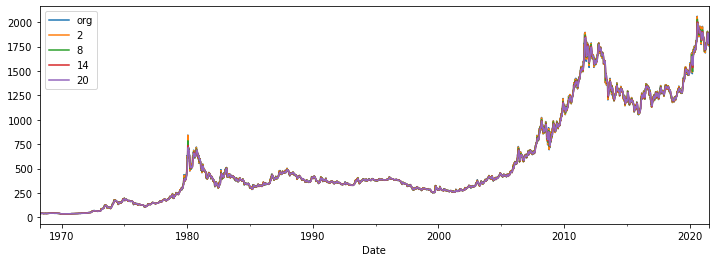

In [15]:
plt.figure(figsize=(12,4))
df.gold.plot(label="org")
for i in range(2,24,6):
    df["gold"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [16]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

Simple Exponential Method

In [22]:
ses_model = SimpleExpSmoothing(model_train["gold"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = valid.index[0],end = valid.index[-1])
MAPE(pred_ses,valid.gold) 


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


12.434920273510475

Holt method

In [23]:
# Holt method 
hw_model = Holt(model_train["gold"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = valid.index[0],end = valid.index[-1])
MAPE(pred_hw,valid.gold) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


144.2708338873959

Holts winter exponential smoothing with additive seasonality and additive trend

In [24]:
hwe_model_add_add = ExponentialSmoothing(model_train["gold"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = valid.index[0],end = valid.index[-1])
MAPE(pred_hwe_add_add,valid.gold) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


13.204093531459451

Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [25]:
hwe_model_mul_add = ExponentialSmoothing(model_train["gold"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = valid.index[0],end = valid.index[-1])
MAPE(pred_hwe_mul_add,valid.gold)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


20.976474472235747

Final Model by combining train and test

In [26]:
ses_model = SimpleExpSmoothing(df["gold"]).fit(smoothing_level=0.2)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [27]:
ses_model.forecast(30)

2021-07-22    1810.227364
2021-07-23    1810.227364
2021-07-24    1810.227364
2021-07-25    1810.227364
2021-07-26    1810.227364
2021-07-27    1810.227364
2021-07-28    1810.227364
2021-07-29    1810.227364
2021-07-30    1810.227364
2021-07-31    1810.227364
2021-08-01    1810.227364
2021-08-02    1810.227364
2021-08-03    1810.227364
2021-08-04    1810.227364
2021-08-05    1810.227364
2021-08-06    1810.227364
2021-08-07    1810.227364
2021-08-08    1810.227364
2021-08-09    1810.227364
2021-08-10    1810.227364
2021-08-11    1810.227364
2021-08-12    1810.227364
2021-08-13    1810.227364
2021-08-14    1810.227364
2021-08-15    1810.227364
2021-08-16    1810.227364
2021-08-17    1810.227364
2021-08-18    1810.227364
2021-08-19    1810.227364
2021-08-20    1810.227364
Freq: D, dtype: float64